# Predictive Maintenance using Machine Learning Technics - using NASA Turbofan Engine Degradation Simulation Data Set

________________

###THIS IS THE CODE TO MOUNT GOOGLE DRIVE AND ACCESS DATA FROM THERE FOR RUNNING THE CODE

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# 2. Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#######################################################################################################

## 0. Importing Libraries for data analysis and visualization

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

## 1. Importing and understanding the data 

### 1.1. Data Source

This data set is provided by Nasa's Prognostics Data Repository and can be obtained from following link (Data set #6):

https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

### 1.2. About the data

This is one of the most popular data set in the data science community in order to learn, practice, and expriment on the predective maintenance algorithms.

The data seems to be very clean as there are no missing values, NaNs, or false type.

The data bundle consists of 4 data sets FD001 to FD004 where each represents different conditions and fault modes for the turbofan engines.

Each data set has 3 files consisting of training, testing, and true Remaining useful life (RUL) of test results.

I recommend you to read the readme.txt file which is provided along the data set.

I tried all of the 4 data sets available and found that data sets FD002 and FD004 show very negligible corelation between the independent variables (i.e. sensor measurements and operational settings) and the dependent variable (RUL). You can also try just by changing the name of the file in the following code block and run the notebook till the correlation heatmap is dispalyed.

Furthermore, there are many models already trained on the FD001.txt so i decided to use FD003 data set. 

### 1.3. Reading the data

Firstly, we make a list of column headers according to the given readme.txt file along with the data set

Then, we use .read_csv method to obtain the data in respective data frame

In [4]:
columns = ['unit_no', 'cycles', 'os_1', 'os_2', 'os_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 
          's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']
df_train = pd.read_csv(("drive/My Drive/Final Data/CMAPSSData/train_FD003.txt"), sep ='\s+', header=None, names = columns)
df_test = pd.read_csv(("drive/My Drive/Final Data/CMAPSSData/test_FD003.txt"), sep ='\s+', header=None, names = columns)
df_RUL = pd.read_csv(("drive/My Drive/Final Data/CMAPSSData/RUL_FD003.txt"), sep ='\s+', header=None, names = ['RUL'])

### 1.4. Checking the data

Checking the train, test and RUL data frames

In [5]:
df_train.head()

,unit_no,cycles,os_1,os_2,os_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


In [6]:
df_test.head()

,unit_no,cycles,os_1,os_2,os_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,21.58,554.56,2387.93,9048.65,1.3,47.09,521.89,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,21.58,554.10,2387.94,9046.53,1.3,47.08,521.85,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,21.58,554.41,2387.97,9054.92,1.3,47.15,522.10,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,21.59,554.58,2387.94,9055.04,1.3,47.26,522.45,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,21.58,554.16,2388.01,9048.59,1.3,46.94,521.91,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950


In [7]:
df_RUL.head()

,RUL
0,44
1,51
2,27
3,120
4,101


As mentioned above, data is very clean and has no NaNs. This can be seen below.

So, no further cleaning necessary.

In [8]:
df_train.isnull().sum()

unit_no    0
cycles     0
os_1       0
os_2       0
os_3       0
s_1        0
s_2        0
s_3        0
s_4        0
s_5        0
s_6        0
s_7        0
s_8        0
s_9        0
s_10       0
s_11       0
s_12       0
s_13       0
s_14       0
s_15       0
s_16       0
s_17       0
s_18       0
s_19       0
s_20       0
s_21       0
dtype: int64

In [9]:
df_train.describe()

,unit_no,cycles,os_1,os_2,os_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,24720.000000,24720.000000,24720.000000,24720.000000,24720.0,2.472000e+04,24720.000000,24720.000000,24720.000000,2.472000e+04,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,2.472000e+04,24720.000000,24720.0,24720.0,24720.000000,24720.000000
mean,48.631877,139.077063,-0.000024,0.000005,100.0,5.186700e+02,642.457858,1588.079175,1404.471212,1.462000e+01,21.595841,555.143808,2388.071555,9064.110809,1.301232,47.415707,523.050873,2388.071643,8144.202916,8.396176,3.000000e-02,392.566545,2388.0,100.0,38.988552,23.393024
std,29.348985,98.846675,0.002194,0.000294,0.0,6.684921e-11,0.523031,6.810418,9.773178,3.602525e-12,0.018116,3.437343,0.158285,19.980294,0.003485,0.300074,3.255314,0.158121,16.504118,0.060512,1.750371e-14,1.761459,0.0,0.0,0.248865,0.149234
min,1.000000,1.000000,-0.008600,-0.000600,100.0,5.186700e+02,640.840000,1564.300000,1377.060000,1.462000e+01,21.450000,549.610000,2386.900000,9017.980000,1.290000,46.690000,517.770000,2386.930000,8099.680000,8.156300,3.000000e-02,388.000000,2388.0,100.0,38.170000,22.872600
25%,23.000000,62.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.080000,1583.280000,1397.187500,1.462000e+01,21.580000,553.110000,2388.000000,9051.920000,1.300000,47.190000,521.150000,2388.010000,8134.510000,8.360600,3.000000e-02,391.000000,2388.0,100.0,38.830000,23.296200
50%,47.000000,124.000000,0.000000,-0.000000,100.0,5.186700e+02,642.400000,1587.520000,1402.910000,1.462000e+01,21.600000,554.050000,2388.070000,9060.010000,1.300000,47.360000,521.980000,2388.070000,8141.200000,8.398300,3.000000e-02,392.000000,2388.0,100.0,38.990000,23.391600
75%,74.000000,191.000000,0.001500,0.000300,100.0,5.186700e+02,642.790000,1592.412500,1410.600000,1.462000e+01,21.610000,556.040000,2388.140000,9070.092500,1.300000,47.600000,523.840000,2388.140000,8149.230000,8.437000,3.000000e-02,394.000000,2388.0,100.0,39.140000,23.483300
max,100.000000,525.000000,0.008600,0.000700,100.0,5.186700e+02,645.110000,1615.390000,1441.160000,1.462000e+01,21.610000,570.490000,2388.600000,9234.350000,1.320000,48.440000,537.400000,2388.610000,8290.550000,8.570500,3.000000e-02,399.000000,2388.0,100.0,39.850000,23.950500


## 2. Adding RUL column

### 2.1. Adding MaxCycleID column in training data frame

First we extract the maximum number cycles before each engine failed in to seperated data frame 'max_cycles_train' 

In [10]:
max_cycles_train = df_train.groupby(['unit_no'], sort=False)['cycles'].max().reset_index().rename(columns={'cycles':'MaxCycleID'})
max_cycles_train.head()

,unit_no,MaxCycleID
0,1,259
1,2,253
2,3,222
3,4,272
4,5,213


Then, we merge the MaxcycleID into our training data frame according to the 'unit_no'. Fianlly, we add new column 'RUL' in training data frame by subtracting 'MaxCycleID' from 'cycles' column.

In [11]:
df_train = pd.merge(df_train, max_cycles_train, how='inner', on='unit_no')
df_train['RUL'] = df_train['MaxCycleID'] - df_train['cycles']

In [12]:
df_train

,unit_no,cycles,os_1,os_2,os_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,MaxCycleID,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,259,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,259,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,259,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,259,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,259,254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,21.61,551.86,2388.25,9070.82,1.3,48.27,519.66,2388.30,8138.08,8.5036,0.03,394,2388,100.0,38.44,22.9631,152,4
24716,100,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,21.61,551.86,2388.23,9064.60,1.3,48.13,519.91,2388.28,8144.36,8.5174,0.03,395,2388,100.0,38.50,22.9746,152,3
24717,100,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,21.61,551.30,2388.25,9063.45,1.3,48.18,519.44,2388.24,8135.95,8.5223,0.03,396,2388,100.0,38.39,23.0682,152,2
24718,100,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,21.61,550.69,2388.26,9062.22,1.3,48.05,520.01,2388.26,8141.24,8.5148,0.03,395,2388,100.0,38.31,23.0753,152,1


## 3. Exploratory Data Analysis

### 3.1. Finding and visualizing correlation

We check the pearson correlation using .corr() method

In [13]:
df_train_corr = df_train.corr()

In [14]:
df_train_corr

,unit_no,cycles,os_1,os_2,os_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,MaxCycleID,RUL
unit_no,1.000000e+00,-7.719557e-02,-2.637261e-03,-1.647735e-02,NaN,2.278836e-13,2.142365e-02,2.733926e-02,2.437569e-02,-1.833122e-13,7.073506e-02,6.462624e-02,5.008490e-02,5.234111e-02,2.911951e-02,2.919199e-02,6.544703e-02,4.892012e-02,5.163411e-02,-3.526731e-02,-2.178742e-13,2.753001e-02,NaN,NaN,4.770465e-02,4.663360e-02,-1.517940e-01,-7.719557e-02
cycles,-7.719557e-02,1.000000e+00,-3.204547e-03,3.409985e-03,NaN,3.031474e-15,3.007980e-01,3.735059e-01,3.619365e-01,1.078266e-14,-4.185901e-01,5.310147e-01,4.381106e-01,5.078379e-01,5.282200e-01,4.074123e-01,5.381973e-01,4.375629e-01,4.885641e-01,-4.005935e-01,-4.379587e-15,3.861850e-01,NaN,NaN,3.045847e-01,3.110197e-01,5.085547e-01,-4.827442e-01
os_1,-2.637261e-03,-3.204547e-03,1.000000e+00,1.226498e-03,NaN,-1.095630e-16,-2.097719e-03,-4.153895e-03,8.107218e-04,-1.270555e-16,-5.080547e-05,-2.498327e-03,-1.344307e-03,-7.728172e-03,-5.541276e-03,-3.287428e-03,-3.288180e-03,-2.467163e-03,-8.938856e-03,7.103864e-03,-1.689147e-16,1.679459e-03,NaN,NaN,-5.606415e-03,-1.452003e-03,4.875743e-04,3.700464e-03
os_2,-1.647735e-02,3.409985e-03,1.226498e-03,1.000000e+00,NaN,2.888210e-16,5.116601e-03,5.185825e-03,4.128482e-03,5.601763e-16,-6.029077e-03,-2.446117e-03,6.277412e-04,1.231055e-02,-2.698207e-03,2.195226e-03,-1.333090e-03,-1.412952e-03,1.584324e-02,2.108028e-03,2.702074e-16,3.078315e-03,NaN,NaN,-1.031887e-03,-3.563529e-03,2.169112e-03,-1.203761e-03
os_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_1,2.278836e-13,3.031474e-15,-1.095630e-16,2.888210e-16,NaN,1.000000e+00,3.059731e-12,1.157631e-12,1.026455e-12,1.000000e+00,2.222751e-10,5.148937e-13,-1.596702e-10,-3.750771e-13,1.112964e-10,-3.760648e-13,-2.982350e-13,-1.148300e-10,2.551356e-12,2.005395e-13,1.000000e+00,-2.542055e-14,NaN,NaN,-7.838449e-13,-9.991745e-14,1.224107e-14,1.075766e-14
s_2,2.142365e-02,3.007980e-01,-2.097719e-03,5.116601e-03,NaN,3.059731e-12,1.000000e+00,6.405034e-01,7.451674e-01,3.060829e-12,3.147986e-01,1.241670e-01,5.339146e-01,4.412826e-01,2.563875e-01,7.622691e-01,1.417851e-01,5.327449e-01,3.439544e-01,2.329468e-01,3.064030e-12,6.700617e-01,NaN,NaN,-2.462862e-01,-2.413185e-01,-2.848914e-01,-5.905638e-01
s_3,2.733926e-02,3.735059e-01,-4.153895e-03,5.185825e-03,NaN,1.157631e-12,6.405034e-01,1.000000e+00,7.168902e-01,1.157733e-12,2.694627e-01,2.820067e-01,6.379256e-01,5.350744e-01,3.677049e-01,7.460932e-01,2.989409e-01,6.365135e-01,4.542052e-01,7.681983e-02,1.157461e-12,6.772163e-01,NaN,NaN,-9.185085e-02,-8.903528e-02,-2.465121e-01,-6.242357e-01
s_4,2.437569e-02,3.619365e-01,8.107218e-04,4.128482e-03,NaN,1.026455e-12,7.451674e-01,7.168902e-01,1.000000e+00,1.026664e-12,3.191389e-01,1.819760e-01,6.012725e-01,5.097823e-01,3.308336e-01,8.540296e-01,2.021063e-01,6.012540e-01,4.046860e-01,2.167729e-01,1.023872e-12,7.499074e-01,NaN,NaN,-2.350155e-01,-2.301342e-01,-2.903202e-01,-6.572239e-01
s_5,-1.833122e-13,1.078266e-14,-1.270555e-16,5.601763e-16,NaN,1.000000e+00,3.060829e-12,1.157733e-12,1.026664e-12,1.000000e+00,2.222721e-10,5.175297e-13,-1.596705e-10,-3.781579e-13,1.113028e-10,-3.768789e-13,-2.959275e-13,-1.148312e-10,2.549746e-12,2.002766e-13,1.000000e+00,-1.058108e-14,NaN,NaN,-7.854062e-13,-1.001197e-13,1.417613e-14,-4.429649e-15


Visualize the correlation data using heatmap in seaborn library

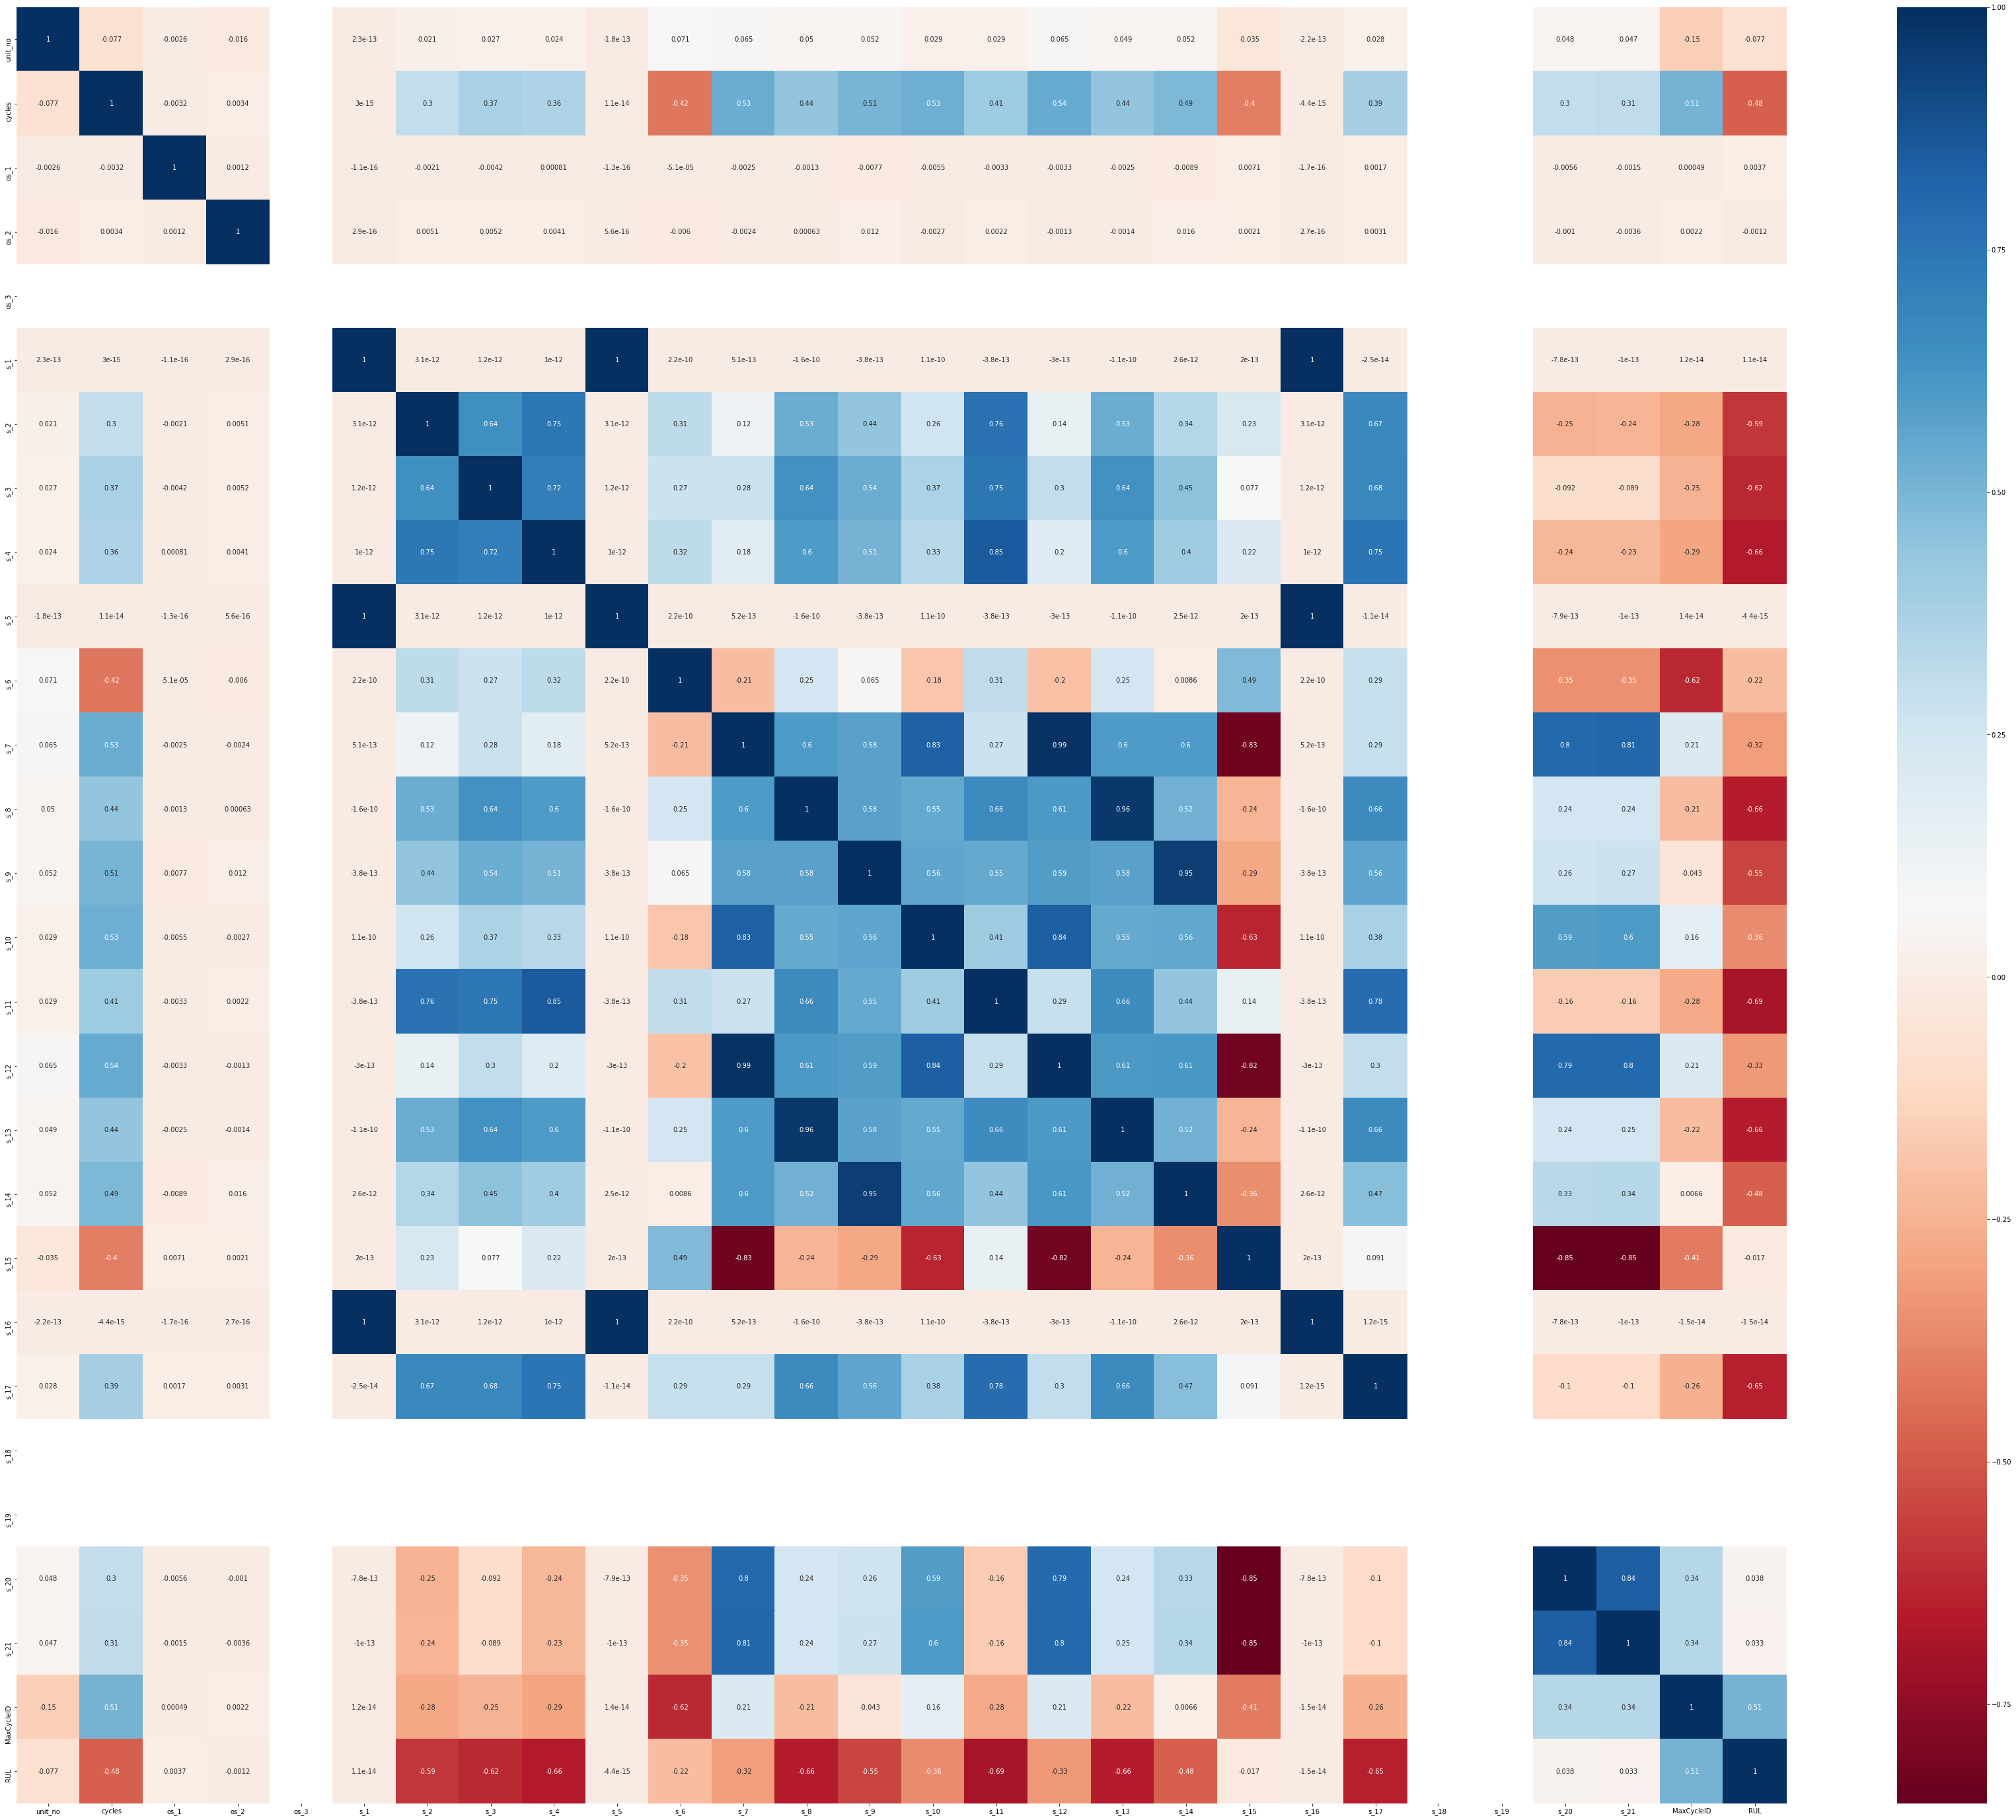

In [15]:
plt.figure(figsize=(60,50))
sns.heatmap(df_train.corr(),annot=True,cmap='RdBu')
#plt.savefig('nasa_turbofan_FD003_Corr.png')

### 3.2. Visualizing the range of RUL

We can see that there are 100 different units tested

In [16]:
len(df_train[df_train['RUL'] == 0])

100

We visualize the range of the RUL in those 100 enteries.

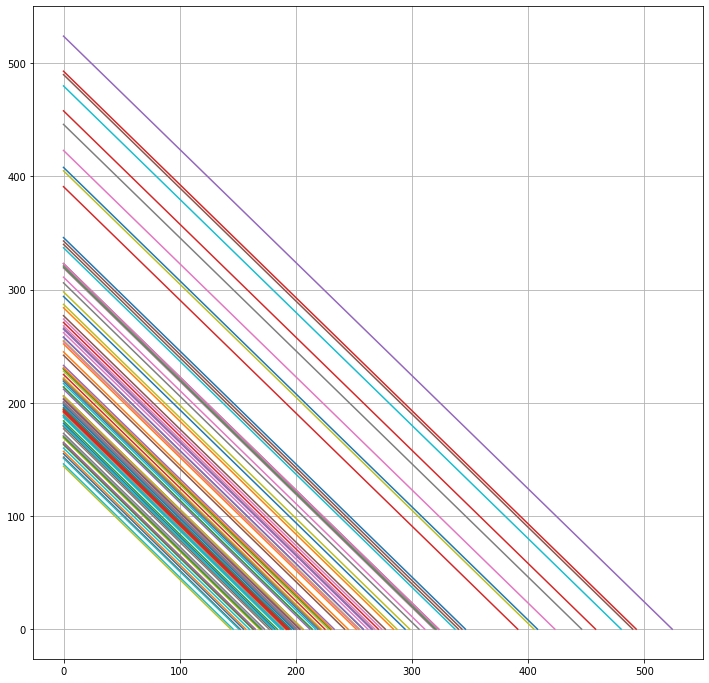

In [17]:
plt.figure(figsize=(12,12))
one_engine = []
for i,r in df_train.iterrows():
    rul = r['RUL']
    one_engine.append(rul)
    if rul == 0:
        plt.plot(one_engine)
        one_engine = []
             
plt.grid()

From above graph we can see that the different engine failed after running varied number of cycles. Most engine units failed between the range 140 to 350 cycles.

This is due to the reason that the engine units are test starting from different wear condition. Some engine units are more wear than other ones.

### 3.3. Function to visualize correlation between sensor data and RUL

In [18]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(20,5))
    for i in df_train['unit_no'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=df_train[df_train['unit_no']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Useful Life')
    plt.grid()
    plt.show()

Visualizing correlation for some sensors

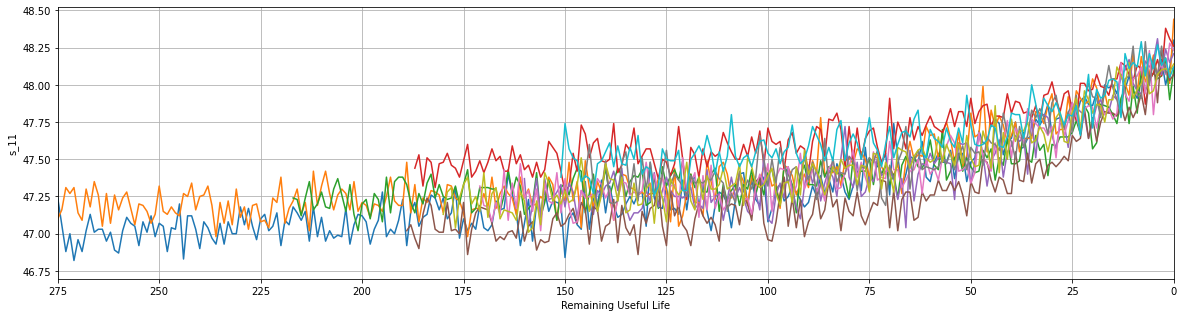

In [19]:
plot_sensor('s_11')

ex. we can a see positive non-linear correlation between sensor 11 and RUL. 

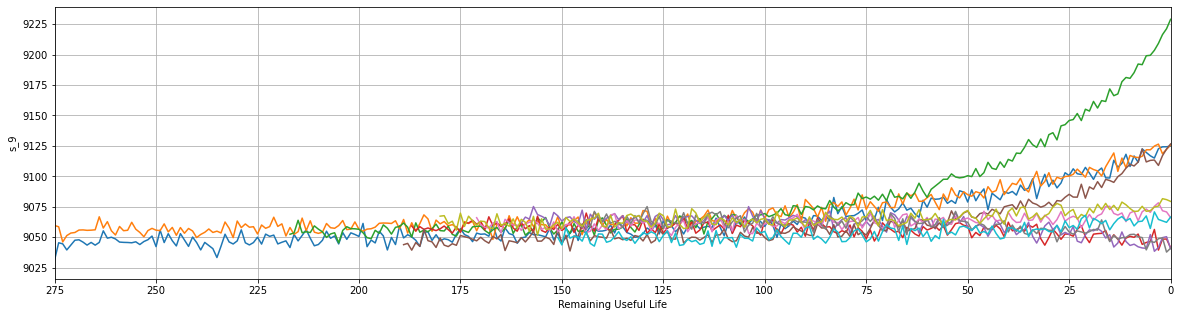

In [20]:
plot_sensor('s_9')

## 4. Feature selection 

From above section and correlation heatmap we can drop the column with least or no correlation with RUL.

In [21]:
df_train = df_train.drop(['os_3', 's_1', 's_5', 's_16', 's_18', 's_19', 'MaxCycleID'],axis=1)

In [22]:
df_train

,unit_no,cycles,os_1,os_2,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL
0,1,1,-0.0005,0.0004,642.36,1583.23,1396.84,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,391,39.11,23.3537,258
1,1,2,0.0008,-0.0003,642.50,1584.69,1396.89,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,392,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,642.18,1582.35,1405.61,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,391,38.85,23.3669,256
3,1,4,-0.0020,0.0001,642.92,1585.61,1392.27,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,392,38.96,23.2951,255
4,1,5,0.0016,0.0000,641.68,1588.63,1397.65,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,392,39.14,23.4583,254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,643.78,1596.01,1424.11,21.61,551.86,2388.25,9070.82,1.3,48.27,519.66,2388.30,8138.08,8.5036,394,38.44,22.9631,4
24716,100,149,0.0034,-0.0003,643.29,1596.38,1429.14,21.61,551.86,2388.23,9064.60,1.3,48.13,519.91,2388.28,8144.36,8.5174,395,38.50,22.9746,3
24717,100,150,-0.0016,0.0004,643.84,1604.53,1431.41,21.61,551.30,2388.25,9063.45,1.3,48.18,519.44,2388.24,8135.95,8.5223,396,38.39,23.0682,2
24718,100,151,-0.0023,0.0004,643.94,1597.56,1426.57,21.61,550.69,2388.26,9062.22,1.3,48.05,520.01,2388.26,8141.24,8.5148,395,38.31,23.0753,1


Similarly, droping the same column from the test data frame

In [23]:
df_test = df_test.drop(['os_3', 's_1', 's_5', 's_16', 's_18', 's_19'],axis=1)

In [24]:
df_test

,unit_no,cycles,os_1,os_2,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,1,-0.0017,-0.0004,641.94,1581.93,1396.93,21.58,554.56,2387.93,9048.65,1.30,47.09,521.89,2387.94,8133.48,8.3760,391,39.07,23.4468
1,1,2,0.0006,-0.0002,642.02,1584.86,1398.90,21.58,554.10,2387.94,9046.53,1.30,47.08,521.85,2388.01,8137.44,8.4062,391,39.04,23.4807
2,1,3,0.0014,-0.0003,641.68,1581.78,1391.92,21.58,554.41,2387.97,9054.92,1.30,47.15,522.10,2387.94,8138.25,8.3553,391,39.10,23.4244
3,1,4,0.0027,0.0001,642.20,1584.53,1395.34,21.59,554.58,2387.94,9055.04,1.30,47.26,522.45,2387.96,8137.07,8.3709,392,38.97,23.4782
4,1,5,-0.0001,0.0001,642.46,1589.03,1395.86,21.58,554.16,2388.01,9048.59,1.30,46.94,521.91,2387.97,8134.20,8.4146,391,39.09,23.3950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16591,100,243,0.0011,-0.0003,643.04,1594.99,1411.28,21.58,561.21,2388.24,9088.31,1.31,47.61,529.23,2388.24,8162.24,8.2939,395,39.40,23.4949
16592,100,244,-0.0024,0.0002,642.47,1591.27,1417.64,21.58,561.02,2388.29,9085.35,1.31,47.75,529.27,2388.26,8163.24,8.3247,394,39.42,23.6011
16593,100,245,-0.0053,0.0002,642.70,1593.81,1412.70,21.58,561.16,2388.23,9084.29,1.31,47.60,529.48,2388.28,8162.12,8.3264,394,39.43,23.5482
16594,100,246,-0.0006,0.0001,642.19,1595.63,1406.58,21.58,562.66,2388.24,9092.52,1.31,47.69,529.39,2388.33,8164.20,8.2908,395,39.40,23.6687


## 5. Adding a binary label to predict probability of failure with in next 30 cycles

Adding the column 'label_1' in which '0' means the engine will not fail and '1' means it will fail given the independent variables. 

Here we have considered a safety margin of 30 cycles.

In [25]:
target_cycles = 30
df_train['label_1'] = np.where(df_train['RUL'] <= target_cycles, 1, 0 )

In [26]:
df_train

,unit_no,cycles,os_1,os_2,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,label_1
0,1,1,-0.0005,0.0004,642.36,1583.23,1396.84,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,391,39.11,23.3537,258,0
1,1,2,0.0008,-0.0003,642.50,1584.69,1396.89,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,392,38.99,23.4491,257,0
2,1,3,-0.0014,-0.0002,642.18,1582.35,1405.61,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,391,38.85,23.3669,256,0
3,1,4,-0.0020,0.0001,642.92,1585.61,1392.27,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,392,38.96,23.2951,255,0
4,1,5,0.0016,0.0000,641.68,1588.63,1397.65,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,392,39.14,23.4583,254,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,643.78,1596.01,1424.11,21.61,551.86,2388.25,9070.82,1.3,48.27,519.66,2388.30,8138.08,8.5036,394,38.44,22.9631,4,1
24716,100,149,0.0034,-0.0003,643.29,1596.38,1429.14,21.61,551.86,2388.23,9064.60,1.3,48.13,519.91,2388.28,8144.36,8.5174,395,38.50,22.9746,3,1
24717,100,150,-0.0016,0.0004,643.84,1604.53,1431.41,21.61,551.30,2388.25,9063.45,1.3,48.18,519.44,2388.24,8135.95,8.5223,396,38.39,23.0682,2,1
24718,100,151,-0.0023,0.0004,643.94,1597.56,1426.57,21.61,550.69,2388.26,9062.22,1.3,48.05,520.01,2388.26,8141.24,8.5148,395,38.31,23.0753,1,1


Visualizing the distribution of binary labels when combining different settings and sensor values

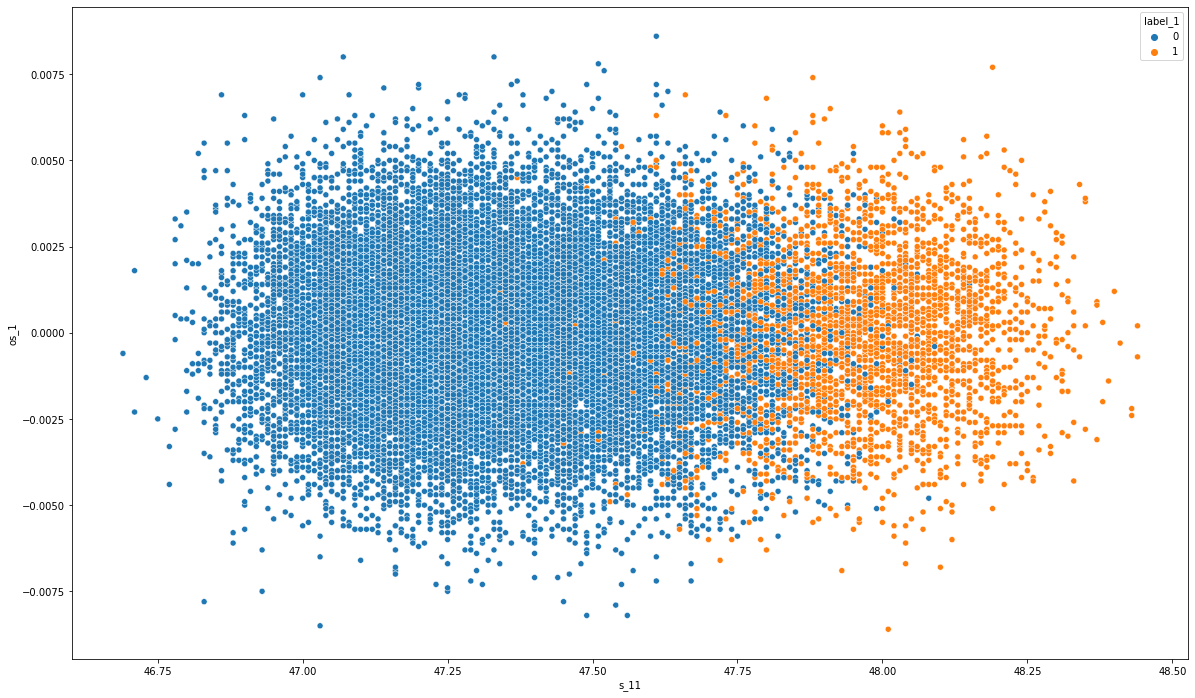

In [27]:
plt.figure(figsize=(20,12))
sns.scatterplot(x="s_11", y="os_1", hue="label_1", data=df_train)

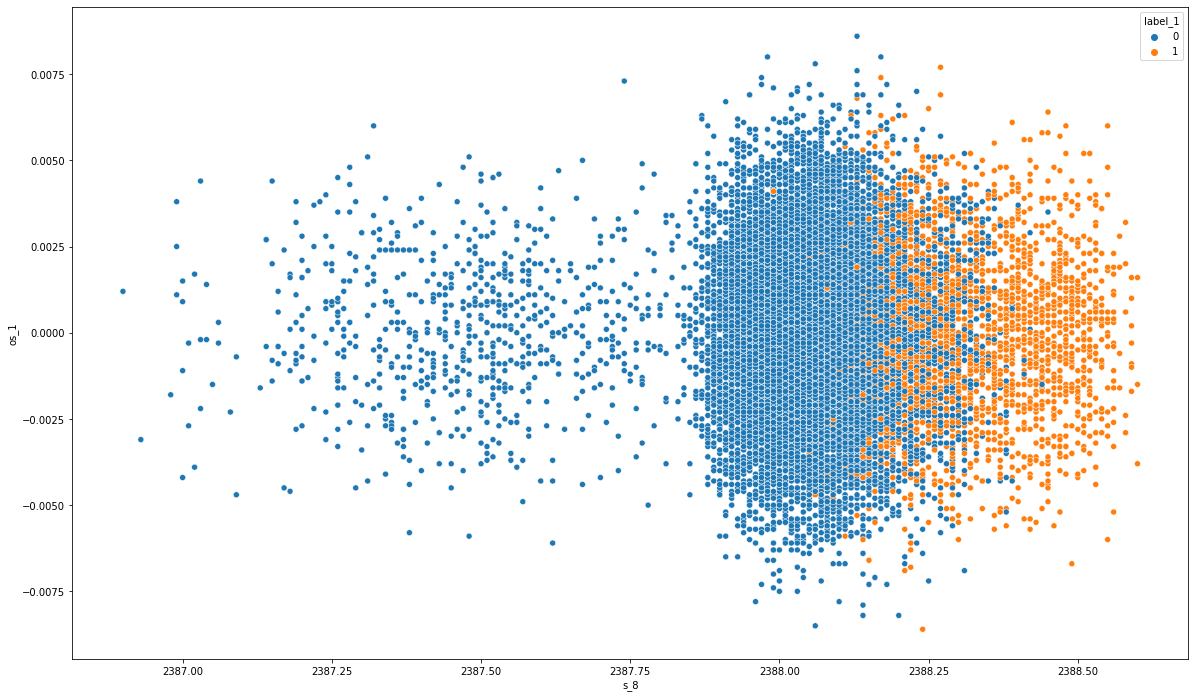

In [28]:
plt.figure(figsize=(20,12))
sns.scatterplot(x="s_8", y="os_1", hue="label_1", data=df_train)

From above plots we can see the separation of the binary labels with different combination of attributes

## 6. Preparing training and testing data set 

### 6.1. Normalizing the training data

We use MinMaxScaler to normalize the selected column between the value 0 and 1.

In [29]:
from sklearn.preprocessing import MinMaxScaler

Applying normalization

In [30]:
scaler = MinMaxScaler()
norm_columns = ['cycles', 'os_1', 'os_2', 's_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 
          's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
df_train.loc[:, norm_columns] = scaler.fit_transform(df_train.loc[:, norm_columns])
#df_test.loc[:, norm_columns] = scaler.fit_transform(df_test.loc[:, norm_columns])

Checking results

In [31]:
df_train

,unit_no,cycles,os_1,os_2,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,label_1
0,1,0.000000,0.470930,0.769231,0.355972,0.370523,0.308580,1.0,0.208812,0.623529,0.204233,0.333333,0.348571,0.231279,0.642857,0.239116,0.647755,0.272727,0.559524,0.446331,258,0
1,1,0.001908,0.546512,0.230769,0.388759,0.399100,0.309360,1.0,0.236590,0.647059,0.202431,0.333333,0.308571,0.236882,0.654762,0.278567,0.685659,0.363636,0.488095,0.534836,257,0
2,1,0.003817,0.418605,0.307692,0.313817,0.353298,0.445398,1.0,0.230843,0.664706,0.241484,0.333333,0.302857,0.217015,0.636905,0.264526,0.564462,0.272727,0.404762,0.458577,256,0
3,1,0.005725,0.383721,0.538462,0.487119,0.417107,0.237285,1.0,0.268199,0.647059,0.215326,0.333333,0.314286,0.240448,0.684524,0.245612,0.558909,0.363636,0.470238,0.391966,255,0
4,1,0.007634,0.593023,0.461538,0.196721,0.476218,0.321217,1.0,0.245690,0.670588,0.268799,0.333333,0.262857,0.245033,0.654762,0.252109,0.556736,0.363636,0.577381,0.543371,254,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,0.280534,0.406977,0.230769,0.688525,0.620669,0.734009,1.0,0.107759,0.794118,0.244211,0.333333,0.902857,0.096281,0.815476,0.201184,0.838484,0.545455,0.160714,0.083960,4,1
24716,100,0.282443,0.697674,0.230769,0.573770,0.627912,0.812480,1.0,0.107759,0.782353,0.215464,0.333333,0.822857,0.109017,0.803571,0.234086,0.871801,0.636364,0.196429,0.094628,3,1
24717,100,0.284351,0.406977,0.769231,0.702576,0.787434,0.847894,1.0,0.080939,0.794118,0.210149,0.333333,0.851429,0.085074,0.779762,0.190025,0.883631,0.727273,0.130952,0.181464,2,1
24718,100,0.286260,0.366279,0.769231,0.725995,0.651008,0.772387,1.0,0.051724,0.800000,0.204465,0.333333,0.777143,0.114111,0.791667,0.217740,0.865524,0.636364,0.083333,0.188051,1,1


In [32]:
df_train['label_1'].value_counts()

0    21620
1     3100
Name: label_1, dtype: int64

We can see that the data has a imbalance with more 0s than 1s

### 6.2. Preparing test data by adding 'RUL' and 'label_1' columns 

In [33]:
rul = pd.DataFrame(df_test.groupby('unit_no')['cycles'].max()).reset_index()
rul.columns = ['unit_no', 'max']
#df_RUL.columns = ['more']
df_RUL['unit_no'] = df_RUL.index + 1
df_RUL['max'] = rul['max'] + df_RUL['RUL']
df_RUL.drop('RUL', axis=1, inplace=True)

In [34]:
df_RUL

,unit_no,max
0,1,277
1,2,175
2,3,261
3,4,188
4,5,239
...,...,...
95,96,471
96,97,218
97,98,199
98,99,297


Adding RUL Column by merging df_RUL to the df_test dataframe

In [35]:
df_test = df_test.merge(df_RUL, on=['unit_no'], how='left')
df_test['RUL'] = df_test['max'] - df_test['cycles']
df_test.drop('max', axis=1, inplace=True)

checking the results

In [36]:
df_test.head(236)

,unit_no,cycles,os_1,os_2,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL
0,1,1,-0.0017,-0.0004,641.94,1581.93,1396.93,21.58,554.56,2387.93,9048.65,1.30,47.09,521.89,2387.94,8133.48,8.3760,391,39.07,23.4468,276
1,1,2,0.0006,-0.0002,642.02,1584.86,1398.90,21.58,554.10,2387.94,9046.53,1.30,47.08,521.85,2388.01,8137.44,8.4062,391,39.04,23.4807,275
2,1,3,0.0014,-0.0003,641.68,1581.78,1391.92,21.58,554.41,2387.97,9054.92,1.30,47.15,522.10,2387.94,8138.25,8.3553,391,39.10,23.4244,274
3,1,4,0.0027,0.0001,642.20,1584.53,1395.34,21.59,554.58,2387.94,9055.04,1.30,47.26,522.45,2387.96,8137.07,8.3709,392,38.97,23.4782,273
4,1,5,-0.0001,0.0001,642.46,1589.03,1395.86,21.58,554.16,2388.01,9048.59,1.30,46.94,521.91,2387.97,8134.20,8.4146,391,39.09,23.3950,272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,1,232,0.0038,-0.0005,642.13,1585.31,1412.28,21.58,560.18,2388.23,9081.79,1.31,47.52,528.93,2388.19,8165.59,8.3044,394,39.21,23.5743,45
232,1,233,0.0021,0.0002,642.59,1592.40,1409.87,21.58,560.53,2388.22,9085.50,1.31,47.53,528.05,2388.23,8158.77,8.2966,393,39.43,23.5679,44
233,2,1,-0.0017,-0.0002,642.50,1585.00,1407.48,21.61,553.62,2388.08,9041.78,1.30,47.36,521.69,2388.10,8131.40,8.4578,393,39.01,23.4496,174
234,2,2,0.0006,0.0002,642.22,1586.69,1402.06,21.61,553.57,2388.09,9046.90,1.30,47.66,521.78,2388.11,8127.63,8.4482,391,38.85,23.3190,173


### 6.3. Adding 'label_1' column with same method used in section 5.

In [37]:
df_test['label_1'] = np.where(df_test['RUL'] <= target_cycles, 1, 0 )

In [38]:
df_test.head(235)

,unit_no,cycles,os_1,os_2,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,label_1
0,1,1,-0.0017,-0.0004,641.94,1581.93,1396.93,21.58,554.56,2387.93,9048.65,1.30,47.09,521.89,2387.94,8133.48,8.3760,391,39.07,23.4468,276,0
1,1,2,0.0006,-0.0002,642.02,1584.86,1398.90,21.58,554.10,2387.94,9046.53,1.30,47.08,521.85,2388.01,8137.44,8.4062,391,39.04,23.4807,275,0
2,1,3,0.0014,-0.0003,641.68,1581.78,1391.92,21.58,554.41,2387.97,9054.92,1.30,47.15,522.10,2387.94,8138.25,8.3553,391,39.10,23.4244,274,0
3,1,4,0.0027,0.0001,642.20,1584.53,1395.34,21.59,554.58,2387.94,9055.04,1.30,47.26,522.45,2387.96,8137.07,8.3709,392,38.97,23.4782,273,0
4,1,5,-0.0001,0.0001,642.46,1589.03,1395.86,21.58,554.16,2388.01,9048.59,1.30,46.94,521.91,2387.97,8134.20,8.4146,391,39.09,23.3950,272,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,1,231,-0.0002,0.0004,642.74,1588.29,1408.17,21.58,560.42,2388.18,9083.52,1.31,47.41,528.41,2388.22,8159.40,8.3349,393,39.34,23.6160,46,0
231,1,232,0.0038,-0.0005,642.13,1585.31,1412.28,21.58,560.18,2388.23,9081.79,1.31,47.52,528.93,2388.19,8165.59,8.3044,394,39.21,23.5743,45,0
232,1,233,0.0021,0.0002,642.59,1592.40,1409.87,21.58,560.53,2388.22,9085.50,1.31,47.53,528.05,2388.23,8158.77,8.2966,393,39.43,23.5679,44,0
233,2,1,-0.0017,-0.0002,642.50,1585.00,1407.48,21.61,553.62,2388.08,9041.78,1.30,47.36,521.69,2388.10,8131.40,8.4578,393,39.01,23.4496,174,0


In [39]:
df_test['label_1'].value_counts()

0    16305
1      291
Name: label_1, dtype: int64

### 6.4. Normalizing the test data

In [40]:
df_test.loc[:, norm_columns] = scaler.fit_transform(df_test.loc[:, norm_columns])

In [41]:
df_test

,unit_no,cycles,os_1,os_2,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,label_1
0,1,0.000000,0.411765,0.166667,0.330128,0.400713,0.345269,0.500000,0.276338,0.636943,0.265810,0.5,0.27500,0.234967,0.628931,0.326196,0.531661,0.363636,0.524476,0.503084,276,0
1,1,0.002110,0.547059,0.333333,0.355769,0.470392,0.384025,0.500000,0.250965,0.643312,0.243832,0.5,0.26875,0.232739,0.672956,0.372280,0.621864,0.363636,0.503497,0.544905,275,0
2,1,0.004219,0.594118,0.250000,0.246795,0.397146,0.246705,0.500000,0.268064,0.662420,0.330811,0.5,0.31250,0.246659,0.628931,0.381706,0.469833,0.363636,0.545455,0.475450,274,0
3,1,0.006329,0.670588,0.583333,0.413462,0.462545,0.313988,0.666667,0.277441,0.643312,0.332055,0.5,0.38125,0.266147,0.641509,0.367974,0.516428,0.454545,0.454545,0.541821,273,0
4,1,0.008439,0.505882,0.583333,0.496795,0.569560,0.324218,0.500000,0.254275,0.687898,0.265188,0.5,0.18125,0.236080,0.647799,0.334575,0.646953,0.363636,0.538462,0.439181,272,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16591,100,0.510549,0.576471,0.250000,0.682692,0.711296,0.627582,0.500000,0.643133,0.834395,0.676965,1.0,0.60000,0.643653,0.817610,0.660887,0.286440,0.727273,0.755245,0.562423,32,0
16592,100,0.512658,0.370588,0.666667,0.500000,0.622830,0.752705,0.500000,0.632653,0.866242,0.646278,1.0,0.68750,0.645880,0.830189,0.672524,0.378435,0.636364,0.769231,0.693437,31,0
16593,100,0.514768,0.200000,0.666667,0.573718,0.683234,0.655518,0.500000,0.640375,0.828025,0.635289,1.0,0.59375,0.657572,0.842767,0.659490,0.383513,0.636364,0.776224,0.628177,30,1
16594,100,0.516878,0.476471,0.583333,0.410256,0.726516,0.535117,0.500000,0.723111,0.834395,0.720610,1.0,0.65000,0.652561,0.874214,0.683696,0.277180,0.727273,0.755245,0.776832,29,1


Train and test data prepared

## 7. Manually splitting independent and dependent data from the training and the testing data frames

In [42]:
features_train_test = ['cycles', 'os_1', 'os_2', 's_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 
          's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

X_train = df_train[features_train_test]
y_train = df_train['label_1']

X_test = df_test[features_train_test]
y_test = df_test['label_1']

## 8. Modelling using Random Forest Classifier

### 8.1. Training Random Forest classifier

Importing modules for training and evaluation

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, fbeta_score

Creating Random Forest classifier object and fitting the training data to the model

In [44]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=0)

# fitting the training data

rf.fit(X_train, y_train)

# predict the test data

y_test_predict = rf.predict(X_test)

#y_train_predict = rf.predict(X_train)

Analysing the resulted value of 0s and 1s

In [45]:
(unique, counts) = np.unique(y_test_predict, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[    0, 15204],
       [    1,  1392]], dtype=int64)

The predicted number of 1s are 1392 and the actual number of 1s are 291 (section 6.3.) 

### 8.2. Evaluating the Random Forest model

We plot the Confussion Matrix by comparing the predicted test values to the actual values 

In [46]:
conf_matrix = confusion_matrix(y_test, y_test_predict)
conf_matrix

array([[15198,  1107],
       [    6,   285]])

We get a true negative count of 15198, true positive count of 285, false positive count of 1107, and false negative count is 6.

Visualizing the confussion matrix

[Text(0.5, 15.0, 'Prediction')]

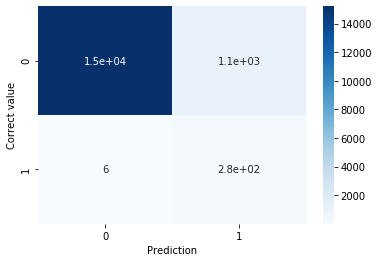

In [ ]:
heatmap = sns.heatmap(conf_matrix, annot=True, cmap='Blues')#, fmt='d')
heatmap.set(ylabel='Correct value')
heatmap.set(xlabel='Prediction')

We evaluate the f1, precision, and recall scores.

In [ ]:
f1_score(y_test, y_test_predict, average='weighted')

0.9537003317410103

In [ ]:
precision_score(y_test, y_test_predict)

0.20474137931034483

In [ ]:
recall_score(y_test, y_test_predict)

0.979381443298969

### 8.3. Random Forest Classifier: Result discussion

As we have seen in above results, the model performs well in terms of recall score but has a lower precision score. This is due to the precision/recall trade-off.

In our case, false negative is more important than the false positive because a failed engine detected as not-failed (only 6 of them are false negatives) leads to danger situations rather than a not-failed engine detected as failed (1107 false positive in our case). It is obvious that we will get some false alerts but most of the time a failed engine is correctly detected as failed.

We get a recall score of approx 98% which is very good considering the importance of false negatives. 

___________________

## 9. Modelling using LSTM Model

 in progress..............